# Conditional Diffusion Models

<div>
<iframe src="https://slides.com/naresh-ub/cvip-lec-15-16-17/embed" width="100%" height="500" title="Intro to GenAI" scrolling="no" frameborder="0" webkitallowfullscreen mozallowfullscreen allowfullscreen></iframe>
</div>

In [4]:
# Cell 1: Pre-train Classifier on MNIST

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# 1) Define the classifier architecture
class SimpleClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool  = nn.AdaptiveAvgPool2d((1,1))
        self.fc    = nn.Linear(128, 10)
        self.act   = nn.ReLU()
    def forward(self, x, t=None):
        h = self.act(self.conv1(x))
        h = self.act(self.conv2(h))
        h = self.pool(h).view(x.size(0), -1)
        return self.fc(h)

# 2) Prepare MNIST data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
mnist_train = datasets.MNIST(root="data", train=True, download=True, transform=transform)
train_loader = DataLoader(mnist_train, batch_size=128, shuffle=True, num_workers=2)

# 3) Instantiate, optimizer, loss
device = 'cuda' if torch.cuda.is_available() else 'cpu'
classifier = SimpleClassifier().to(device)
optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

# 4) Training loop
num_epochs = 10
for epoch in range(1, num_epochs+1):
    classifier.train()
    running_loss = 0.0
    correct = total = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        logits = classifier(x)
        loss = criterion(logits, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * x.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += x.size(0)
    avg_loss = running_loss / total
    acc = correct / total * 100
    print(f"Epoch {epoch}/{num_epochs} — Loss: {avg_loss:.4f}, Accuracy: {acc:.2f}%")

# 5) Save the trained weights
torch.save(classifier.state_dict(), "classifier.pth")
print("Classifier weights saved to classifier.pth")

Epoch 1/10 — Loss: 1.7158, Accuracy: 36.63%
Epoch 2/10 — Loss: 1.2872, Accuracy: 54.67%
Epoch 3/10 — Loss: 1.0956, Accuracy: 62.45%
Epoch 4/10 — Loss: 0.9616, Accuracy: 68.34%
Epoch 5/10 — Loss: 0.8598, Accuracy: 72.36%
Epoch 6/10 — Loss: 0.7695, Accuracy: 76.25%
Epoch 7/10 — Loss: 0.6921, Accuracy: 79.01%
Epoch 8/10 — Loss: 0.6279, Accuracy: 81.30%
Epoch 9/10 — Loss: 0.5758, Accuracy: 82.98%
Epoch 10/10 — Loss: 0.5318, Accuracy: 84.22%
Classifier weights saved to classifier.pth


Training DDPM:   2%|▏         | 9992/500000 [01:59<1:33:04, 87.74it/s] 

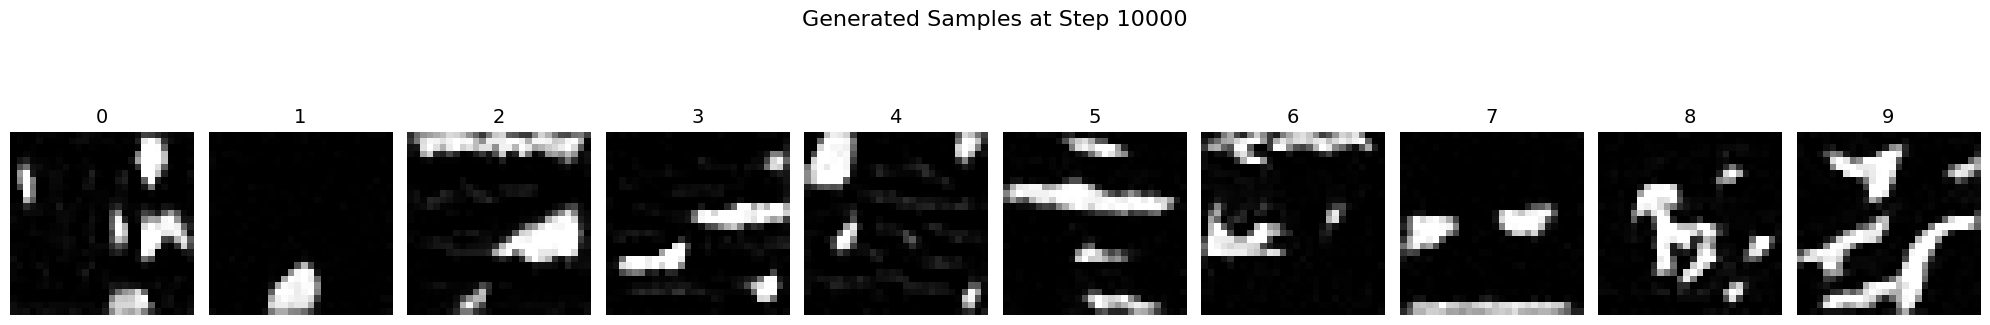

Training DDPM:   4%|▍         | 20000/500000 [04:05<1:17:58, 102.59it/s]

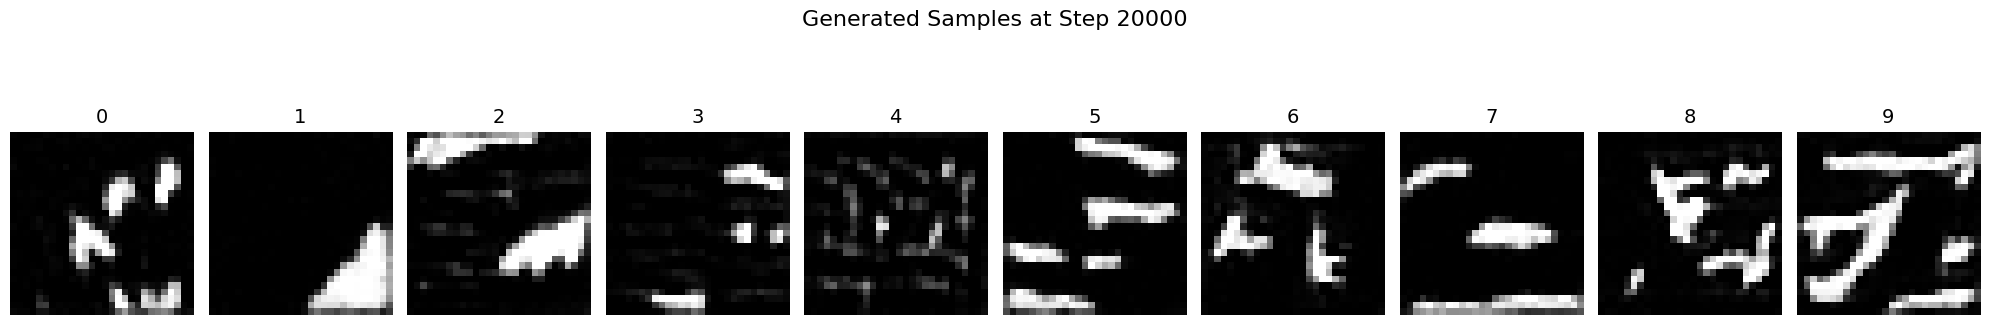

Training DDPM:   6%|▌         | 29993/500000 [06:12<1:28:52, 88.13it/s] 

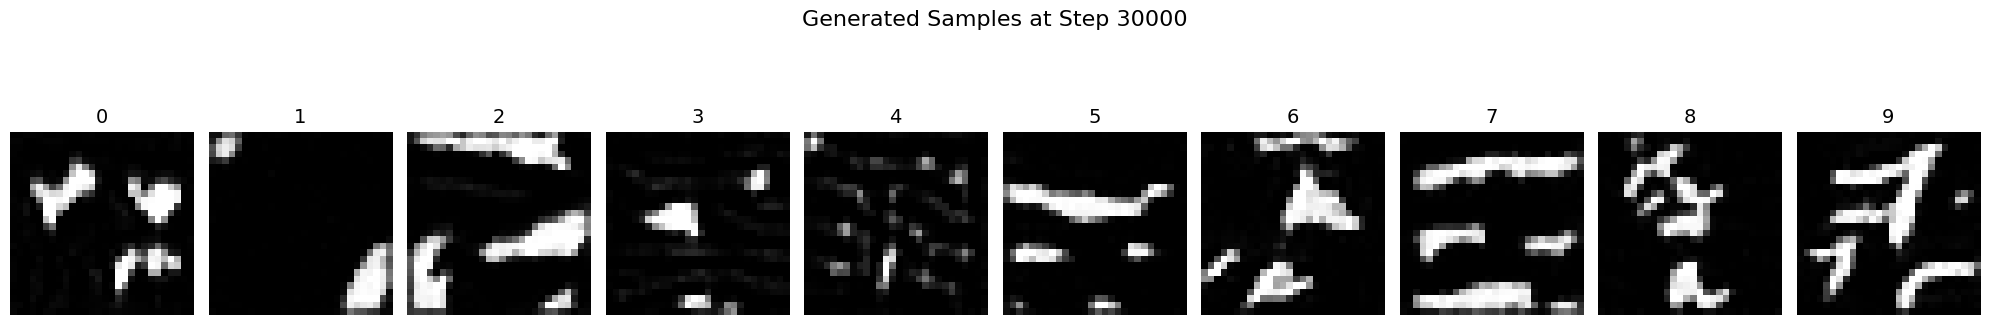

Training DDPM:   8%|▊         | 39995/500000 [08:21<1:34:39, 80.99it/s] 

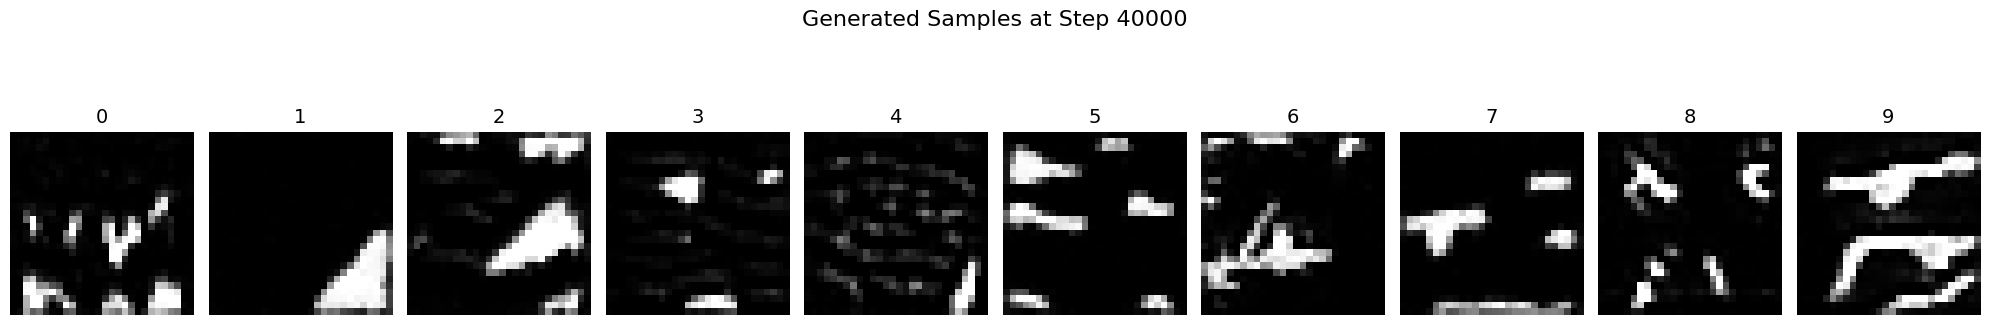

Training DDPM:  10%|█         | 50000/500000 [10:27<1:40:58, 74.28it/s] 

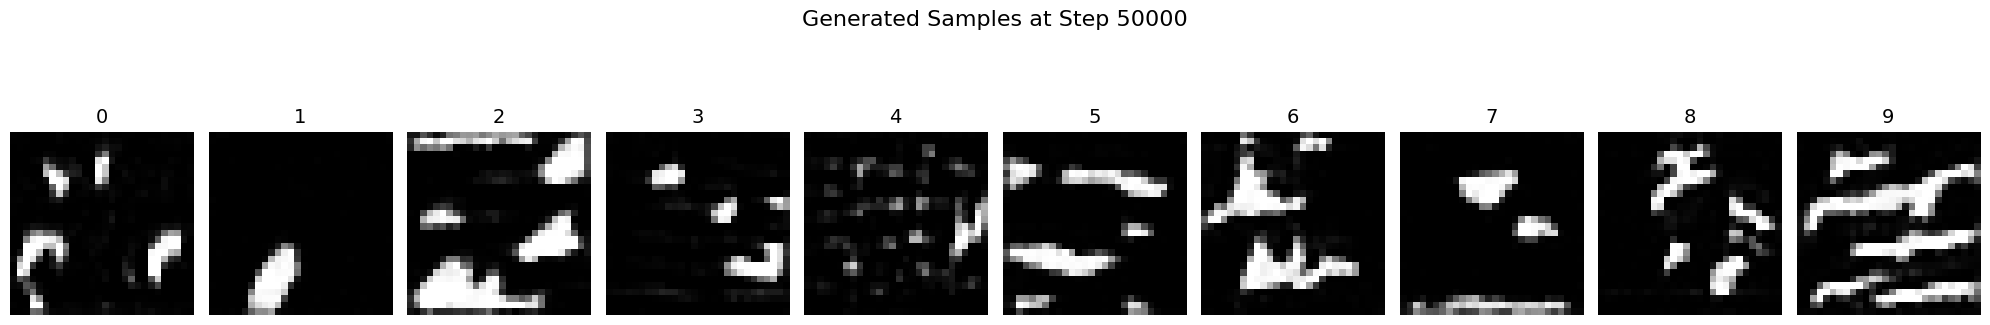

Training DDPM:  12%|█▏        | 59998/500000 [12:31<1:29:20, 82.08it/s] 

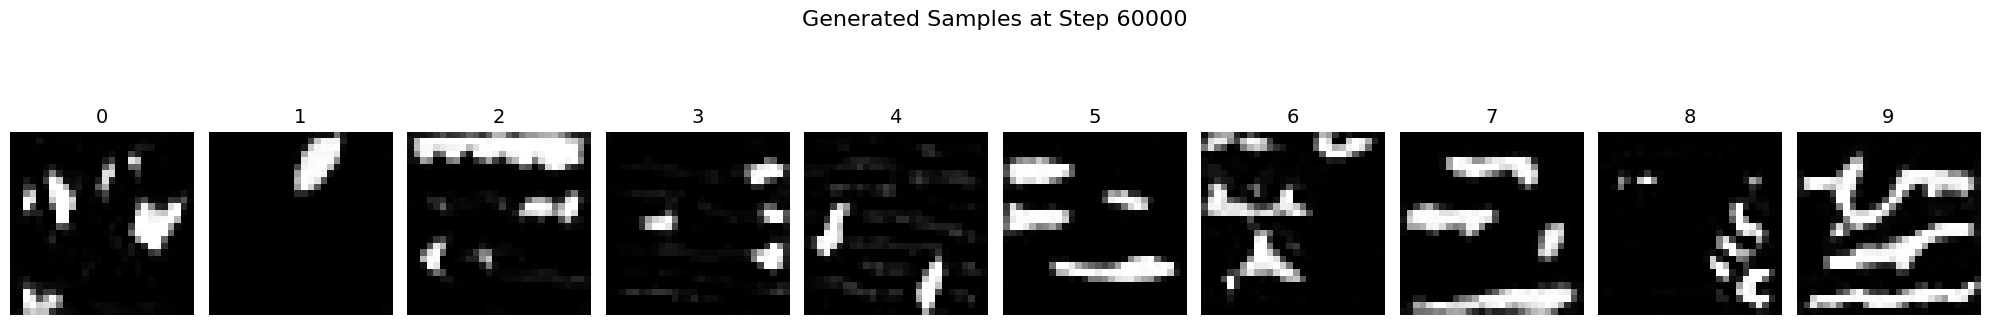

Training DDPM:  14%|█▍        | 69999/500000 [14:38<1:28:21, 81.10it/s] 

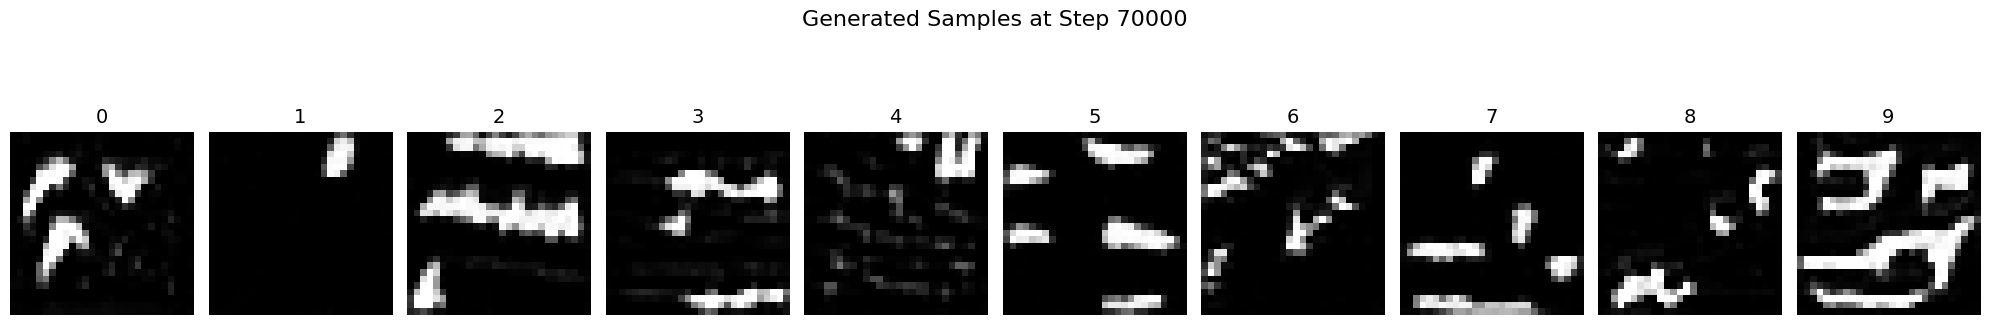

Training DDPM:  16%|█▌        | 79995/500000 [16:41<1:17:13, 90.65it/s] 

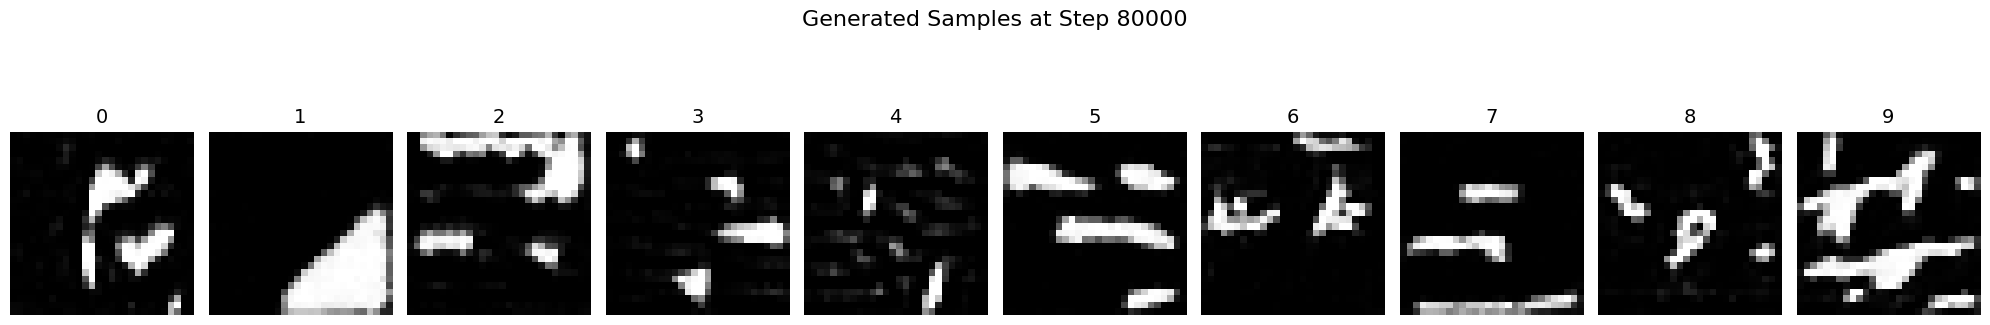

Training DDPM:  18%|█▊        | 89996/500000 [18:43<1:16:15, 89.61it/s] 

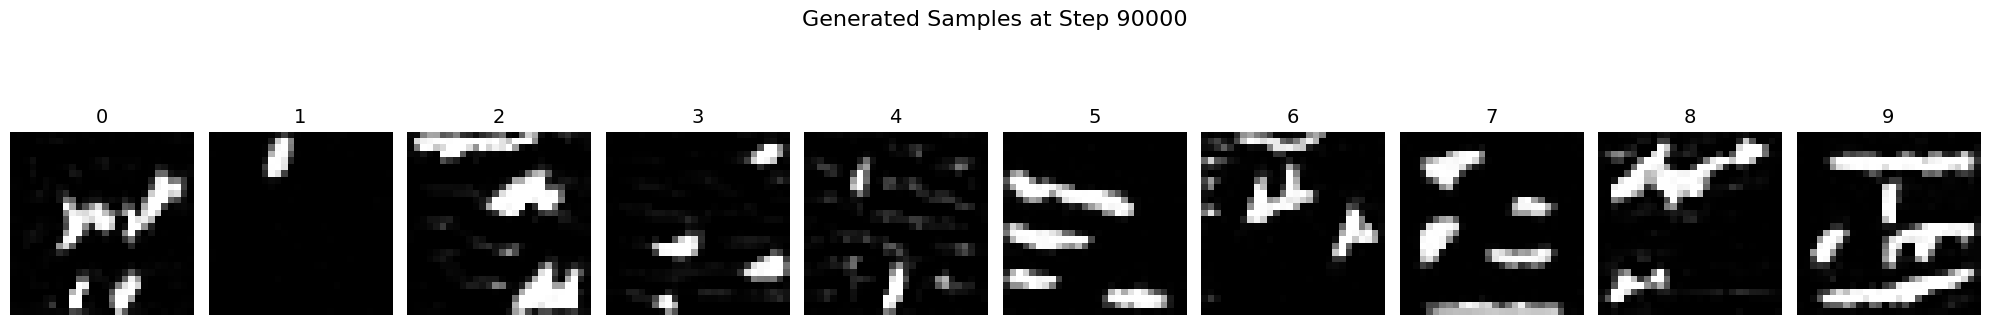

Training DDPM:  20%|█▉        | 99992/500000 [20:48<1:25:50, 77.66it/s] 

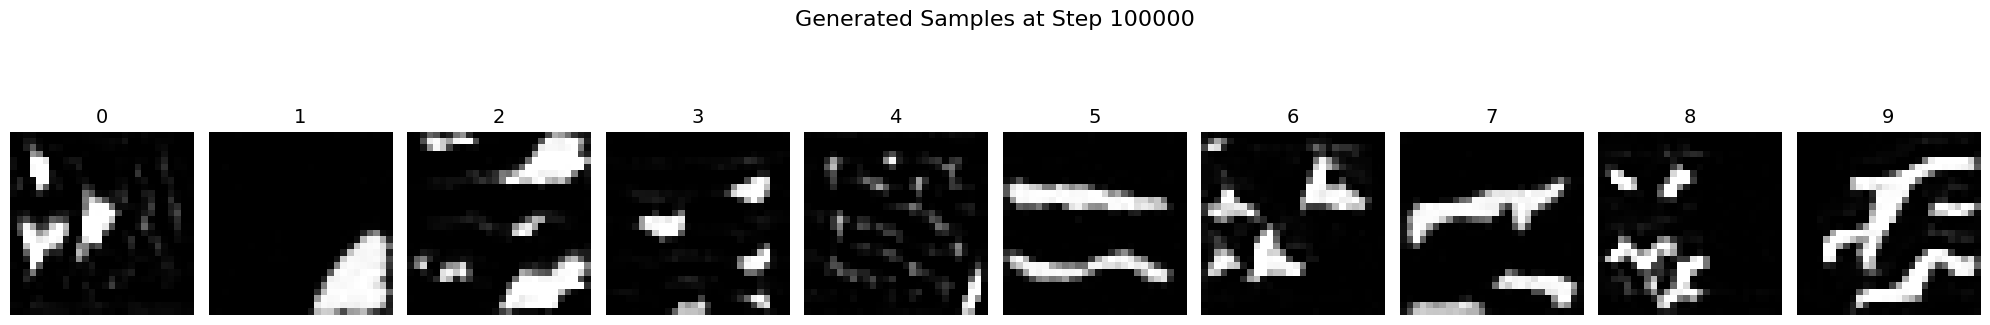

Training DDPM:  22%|██▏       | 109999/500000 [22:56<1:16:26, 85.02it/s] 

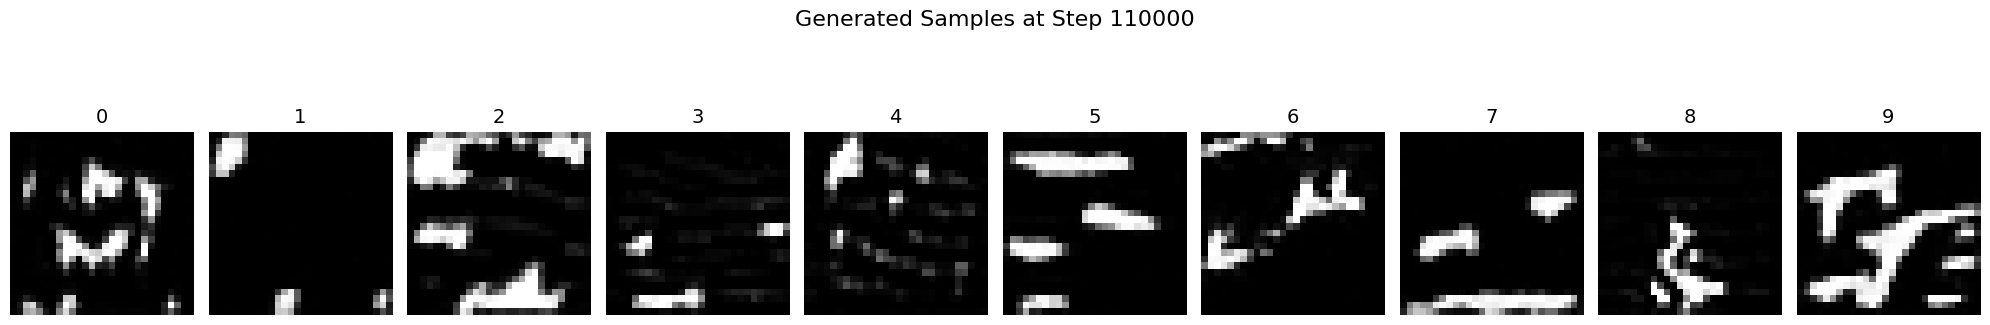

Training DDPM:  24%|██▍       | 119992/500000 [24:56<1:22:49, 76.46it/s] 

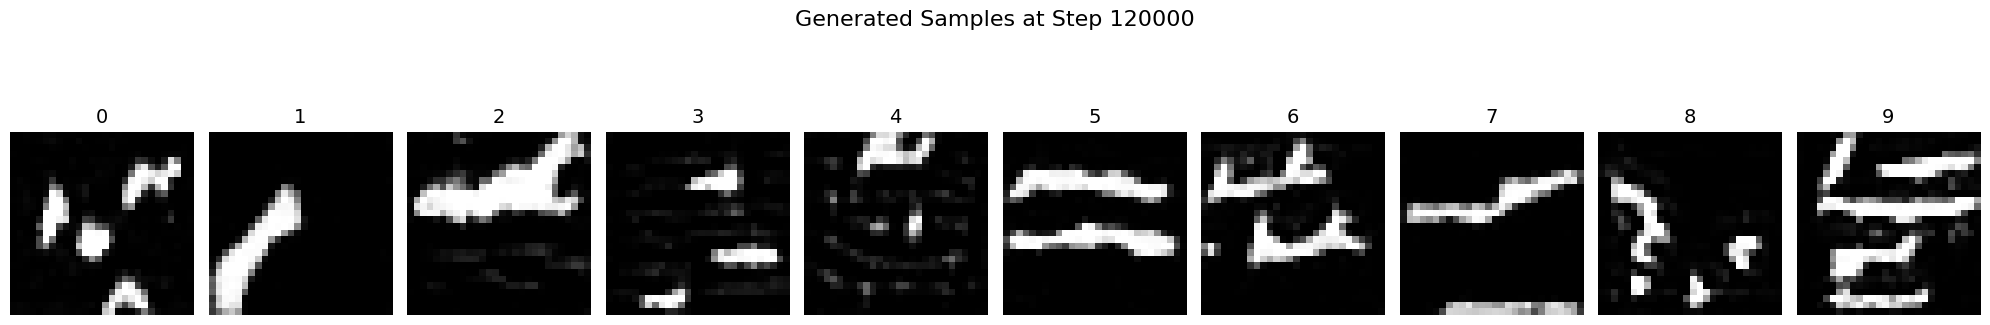

Training DDPM:  26%|██▌       | 130000/500000 [26:59<1:09:13, 89.07it/s] 

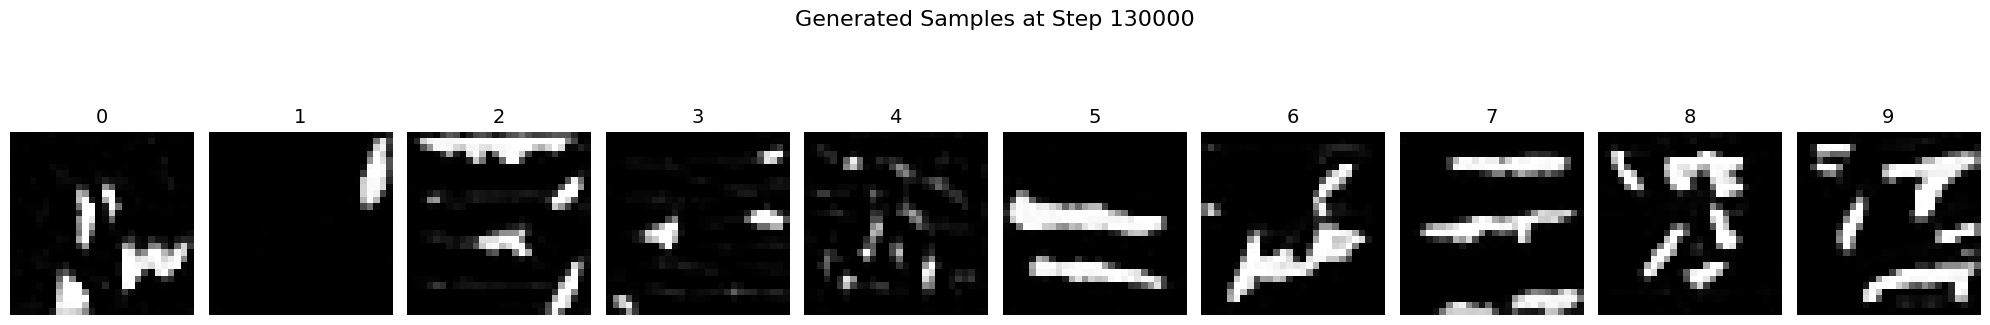

Training DDPM:  28%|██▊       | 139995/500000 [29:01<1:07:39, 88.69it/s] 

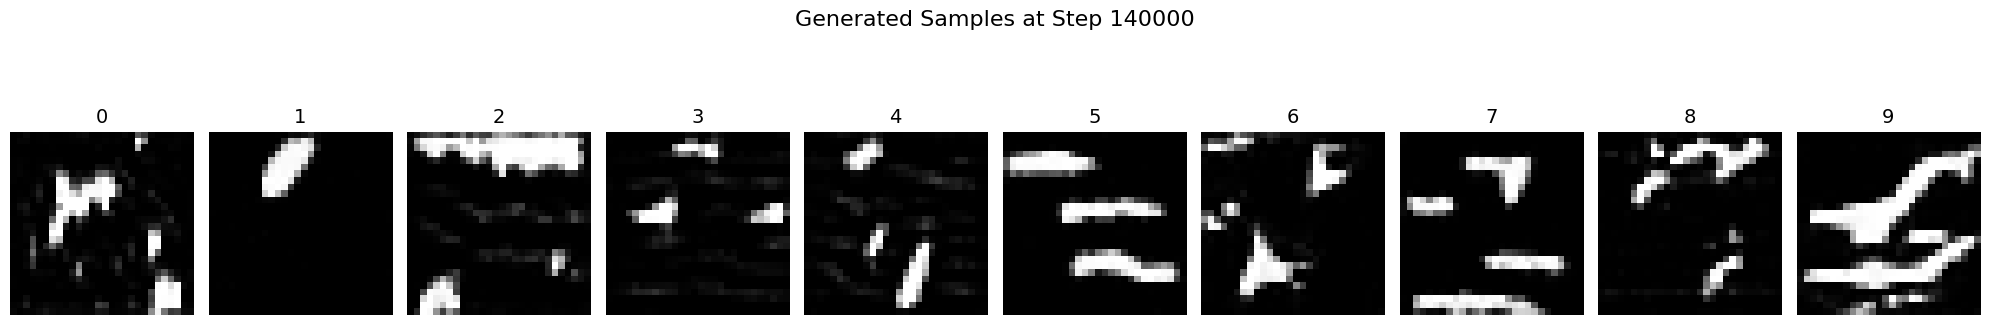

Training DDPM:  30%|██▉       | 149994/500000 [31:04<47:26, 122.95it/s]  

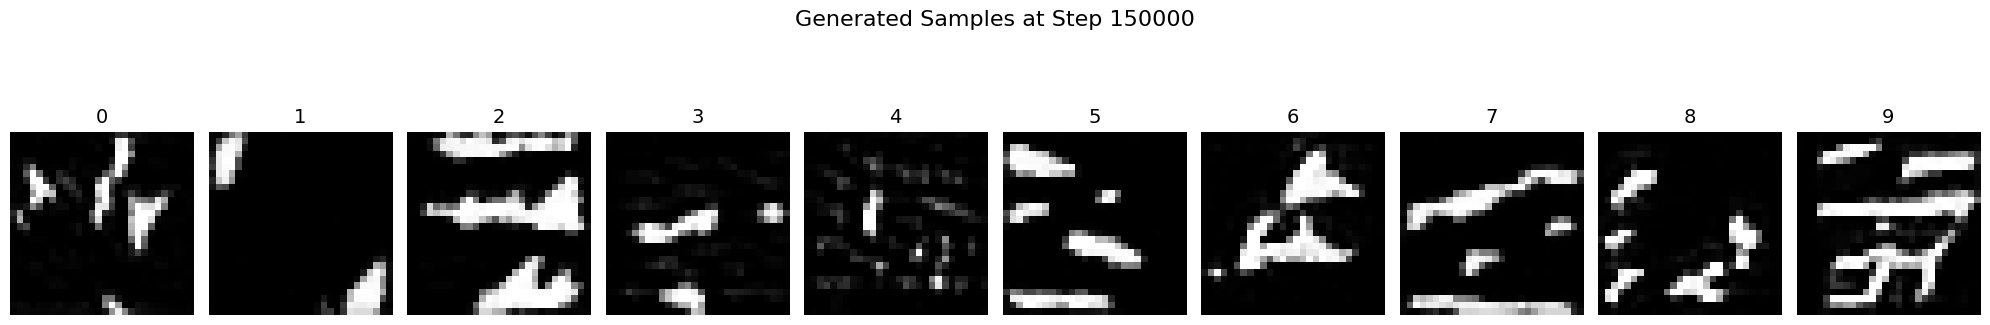

Training DDPM:  32%|███▏      | 159997/500000 [33:00<1:04:57, 87.23it/s] 

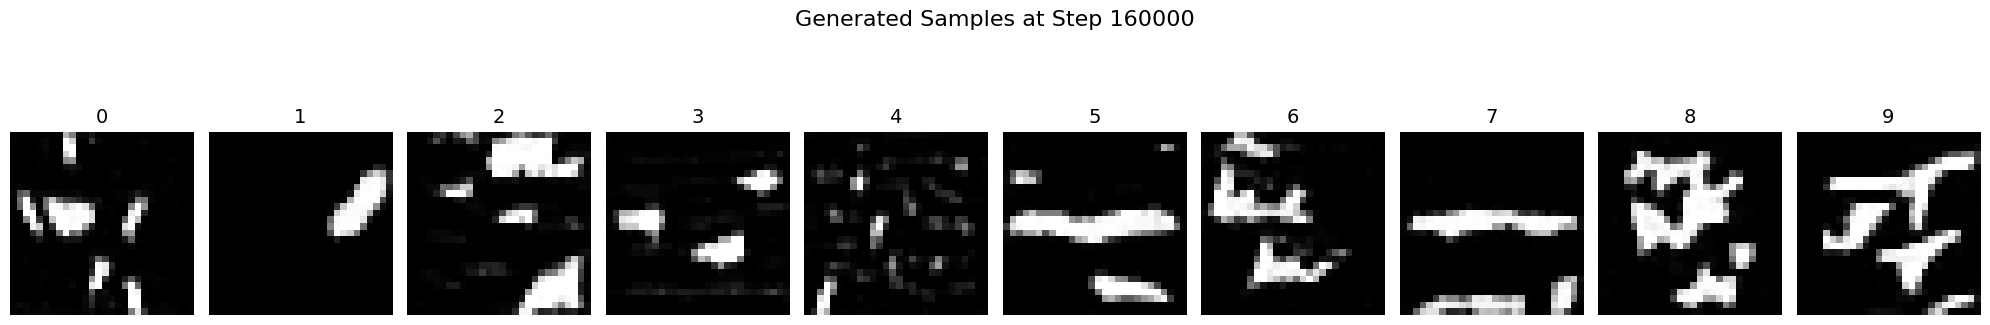

Training DDPM:  33%|███▎      | 163508/500000 [33:47<1:03:25, 88.43it/s] 

In [ ]:
# Cell 2: Train Diffusion Model with Classifier Guidance (with tqdm and detached plotting)

import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm

# -----------------------------------------------------------------------------
# A) Noise Schedule & Timestep Embedding
# -----------------------------------------------------------------------------

def linear_beta_schedule(T, beta_start=1e-4, beta_end=0.02):
    return torch.linspace(beta_start, beta_end, T)

class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, t):
        half_dim = self.dim // 2
        freqs = torch.exp(
            -math.log(10000) * torch.arange(half_dim, device=t.device) / (half_dim - 1)
        )
        args = t[:, None].float() * freqs[None]
        return torch.cat([torch.sin(args), torch.cos(args)], dim=-1)

# -----------------------------------------------------------------------------
# B) Classifier Definition (matches pre-trained classifier)
# -----------------------------------------------------------------------------

class SimpleClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool  = nn.AdaptiveAvgPool2d((1,1))
        self.fc    = nn.Linear(128, 10)
        self.act   = nn.ReLU()

    def forward(self, x, t=None):
        h = self.act(self.conv1(x))
        h = self.act(self.conv2(h))
        h = self.pool(h).view(x.size(0), -1)
        return self.fc(h)

# -----------------------------------------------------------------------------
# C) Denoiser & Diffusion-with-Guidance Definition
# -----------------------------------------------------------------------------

class SimpleUnet(nn.Module):
    def __init__(self, time_dim=32):
        super().__init__()
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(time_dim),
            nn.Linear(time_dim, 64),
            nn.ReLU()
        )
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 1, 3, padding=1)
        self.act   = nn.ReLU()

    def forward(self, x, t):
        t_emb = self.time_mlp(t)[:, :, None, None]  # (B,64,1,1)
        h     = self.act(self.conv1(x))             # (B,32,28,28)
        h     = self.act(self.conv2(h) + t_emb)     # (B,64,28,28)
        return self.conv3(h)                        # (B,1,28,28)

class DiffusionWithGuidance(nn.Module):
    def __init__(self, denoiser, classifier, T=1000):
        super().__init__()
        self.denoiser   = denoiser
        self.classifier = classifier
        self.T          = T
        betas      = linear_beta_schedule(T)
        alphas     = 1 - betas
        alphas_bar = torch.cumprod(alphas, dim=0)
        self.register_buffer('betas',      betas)
        self.register_buffer('alphas',     alphas)
        self.register_buffer('alphas_bar', alphas_bar)

    def sample(self, shape, y, guidance_scale=1.0):
        B = shape[0]
        x = torch.randn(shape, device=self.betas.device)
        for i in reversed(range(self.T)):
            t         = torch.full((B,), i, device=x.device, dtype=torch.long)
            eps       = self.denoiser(x, t)
            beta      = self.betas[i]
            alpha     = self.alphas[i]
            alpha_bar = self.alphas_bar[i]

            coef1 = 1.0 / torch.sqrt(alpha)
            coef2 = beta / torch.sqrt(1 - alpha_bar)
            mean  = coef1 * (x - coef2 * eps)

            # classifier guidance
            x_in   = x.detach().clone().requires_grad_(True)
            logits = self.classifier(x_in)
            log_p  = F.log_softmax(logits, dim=1)
            score  = log_p[range(B), y].sum()
            grad   = torch.autograd.grad(score, x_in)[0]

            mean = mean + guidance_scale * grad

            if i > 0:
                noise = torch.randn_like(x)
                x = mean + torch.sqrt(beta) * noise
            else:
                x = mean
        return x.clamp(-1, 1)

# -----------------------------------------------------------------------------
# D) Data, Models & Optimizer
# -----------------------------------------------------------------------------

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
mnist  = datasets.MNIST(root="data", train=True, download=True, transform=transform)
loader = DataLoader(mnist, batch_size=128, shuffle=True, num_workers=2)

device   = 'cuda' if torch.cuda.is_available() else 'cpu'
denoiser = SimpleUnet().to(device)

classifier = SimpleClassifier().to(device)
classifier.load_state_dict(torch.load("classifier.pth", map_location=device))
classifier.eval()
for p in classifier.parameters():
    p.requires_grad = False

diffusion = DiffusionWithGuidance(denoiser, classifier, T=1000).to(device)
optimizer = torch.optim.Adam(denoiser.parameters(), lr=1e-4)
mse_loss  = nn.MSELoss()

# -----------------------------------------------------------------------------
# E) Training Loop + Sampling Plots (with tqdm)
# -----------------------------------------------------------------------------

total_steps = 500000
plot_every  = 10000
step        = 0
pbar        = tqdm(total=total_steps, desc="Training DDPM")

def plot_row(images, title):
    # Increase overall figure size and individual image sizes
    fig, axs = plt.subplots(1, 10, figsize=(20, 4))  # was (10, 1), now wider and taller
    for i in range(10):
        img = images[i].squeeze().detach().cpu()
        axs[i].imshow(img, cmap='gray', vmin=-1, vmax=1)
        axs[i].axis('off')
        axs[i].set_title(str(i), fontsize=14)          # larger title font
    plt.suptitle(title, fontsize=16)                   # larger suptitle font
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])          # make room for the suptitle
    plt.show()

while step < total_steps:
    for xb, _ in loader:
        xb = xb.to(device)
        bsz = xb.size(0)

        t         = torch.randint(0, diffusion.T, (bsz,), device=device)
        noise     = torch.randn_like(xb)
        alpha_bar = diffusion.alphas_bar[t][:, None, None, None]
        xt        = torch.sqrt(alpha_bar) * xb + torch.sqrt(1 - alpha_bar) * noise

        eps_pred = denoiser(xt, t)
        loss_d   = mse_loss(eps_pred, noise)
        optimizer.zero_grad()
        loss_d.backward()
        optimizer.step()

        step += 1
        pbar.update(1)

        if step % plot_every == 0:
            y   = torch.arange(10, device=device)
            gen = diffusion.sample((10, 1, 28, 28), y, guidance_scale=5.0)
            plot_row(gen, f"Generated Samples at Step {step}")

        if step >= total_steps:
            break

pbar.close()

# final samples
y         = torch.arange(10, device=device)
final_gen = diffusion.sample((10, 1, 28, 28), y, guidance_scale=5.0)
plot_row(final_gen, "Final Generated Samples")

In [ ]:
# Pseudocode: Classifier-Free Guidance Sampling

def classifier_free_guidance_sampling(
    denoiser,             # function: x, t, condition -> predicted noise
    total_steps,          # integer T
    beta_list,            # list of length T: beta values
    guidance_scale,       # float s
    condition,            # desired condition embedding or label
    shape                 # tuple (C, H, W)
):
    # Precompute schedules
    alpha_list = [1.0 - beta for beta in beta_list]
    alpha_bar_list = []
    cum = 1.0
    for alpha in alpha_list:
        cum *= alpha
        alpha_bar_list.append(cum)
    
    # Start from pure Gaussian noise x_T
    x = sample_normal(mean=0, std=1, shape=shape)
    
    # Reverse diffusion
    for t in range(total_steps, 0, -1):
        # Predict noise for conditional and unconditional
        noise_cond = denoiser(x, t, condition)
        noise_uncond = denoiser(x, t, None)
        
        # Classifier-free guidance combination
        noise_guided = noise_uncond + guidance_scale * (noise_cond - noise_uncond)
        
        # Compute coefficients
        beta_t = beta_list[t-1]
        alpha_t = alpha_list[t-1]
        alpha_bar_t = alpha_bar_list[t-1]
        coef1 = 1.0 / sqrt(alpha_t)
        coef2 = beta_t / sqrt(1.0 - alpha_bar_t)
        
        # Compute posterior mean
        mean = coef1 * (x - coef2 * noise_guided)
        
        # Sample next x
        if t > 1:
            z = sample_normal(mean=0, std=1, shape=shape)
            sigma_t = sqrt(beta_t)
            x = mean + sigma_t * z
        else:
            x = mean  # final step, no noise
    
    return x  # x_0: generated sample